In [90]:
import pandas, keras
import numpy as np
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks

In [91]:
# 1 image has 16x16 pixels = 256 pixels
pixels = ["pixel_{0}".format(i) for i in range(36)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,6,6), axis=-1)


#store_train = pandas.HDFStore("SNG_p10_pixelTrain.h5")
store_train = pandas.HDFStore("pixelTrain.h5")
#store_train = pandas.HDFStore("pixelTrain.h5")

df_train = store_train.select("df",stop=-1)
df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]
#images_train = to_image(df_train)

store_test = pandas.HDFStore("pixelTrain30k.h5")

df_test = store_test.select("df",stop=-1)
df_test = df_test[(df_test["GenDeltaR"]<0.1) & (df_test["nUniqueSimTracksInSharedHit"]>-1)]#print(df_test)
images_test = to_image(df_test)

#comb = pandas.concat([df_train,df_test])

#df_train=comb.sample(frac=0.6)
#df_test=comb.drop(df_train.index)

#df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]

# Make all test, train data merged hit
df_test = df_test[(df_test["isSharedHit"]>0)]
df_train = df_train[(df_train["isSharedHit"]>0)]

#images_train = to_image(df_train)
#images_test = to_image(df_test)


#print(df_train.iloc[[28946]])
#print(df_train)
#print df_train
#print sum(df_train["isSharedHit"])


In [92]:
store_train = pandas.HDFStore("pixelTrain.h5")

df_train = store_train.select("df",stop=-1)
df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]

store_test = pandas.HDFStore("pixelTrain30k.h5")

df_test = store_test.select("df",stop=-1)
df_test = df_test[(df_test["GenDeltaR"]<0.1) & (df_test["nUniqueSimTracksInSharedHit"]>-1)]#print(df_test)

print df_test.shape
print df_train.shape

# Remove overlap between train and test data
df_combined = pandas.concat([df_test, df_train]).drop_duplicates(keep=False)
df_combined.shape


# New combined files
df_train=df_combined.sample(frac=0.6)
df_test=df_combined.drop(df_train.index)

# Make all test, train data merged hit
df_test = df_test[(df_test["isSharedHit"]>0)]
df_train = df_train[(df_train["isSharedHit"]>0)]

df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]


images_train = to_image(df_train)
images_test = to_image(df_test)


(82, 42)
(313, 42)


In [93]:
# Adding isMergedHit column 

merged_hit = df_train["nUniqueSimTracksInSharedHit"]>1
merged_int = merged_hit.astype(int)
df_train.insert(0, "isMergedHit", merged_int, True)

#df_train.head()

merged_hit_test = df_test["nUniqueSimTracksInSharedHit"]>1
merged_int_test = merged_hit_test.astype(int)
df_test.insert(0, "isMergedHit", merged_int_test, True)

df_test.head()

,isMergedHit,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35
25,0,1,1.929511,-2.201498,1.929511,1.0,0.014203,0.0,0.0,0.0,...,0.074612,0.040008,0.000000,0.0,0.0,0.0,0.107974,0.000000,0.000000,0.0
92,0,1,1.927646,-2.203123,1.927646,1.0,0.016287,0.0,0.0,0.0,...,0.000000,0.403630,0.056244,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
140,0,1,4.689703,-2.010829,4.689703,1.0,0.032041,0.0,0.0,0.0,...,0.000000,0.193271,0.000000,0.0,0.0,0.0,0.000000,0.182736,0.000000,0.0
324,1,1,9.880289,-1.865279,9.880289,2.0,0.002863,0.0,0.0,0.0,...,0.000000,0.137176,0.069709,0.0,0.0,0.0,0.000000,0.073712,0.101975,0.0
331,1,1,1.467527,-2.182899,1.467527,2.0,0.003103,0.0,0.0,0.0,...,0.000000,0.222396,0.000000,0.0,0.0,0.0,0.000000,0.190251,0.000000,0.0


In [94]:
from sklearn.model_selection import train_test_split
X = df_train.iloc[:,np.r_[1:4, 6:43]]
Y = df_train['isMergedHit']
#train_SharedHit = images_train['isMergedHit']

x_final_test = df_test.iloc[:,np.r_[1:4, 6:43]]
y_final_test = df_test['isMergedHit']

# Splitting train data into training and validation datasets
x_train, x_test, y_train_v, y_test_v = train_test_split(X, Y, test_size = 0.4, random_state = 2)

print Y.shape
print X.shape


(174,)
(174, 40)


In [95]:
# Random Forest
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

# Defining Model

clf = RandomForestClassifier(n_estimators = 50)

clf.fit(x_train, y_train_v)

# Predictions on training 
y_pred_train = clf.predict(x_train)

# Predictions for test
y_pred_test = clf.predict(x_test)

# Training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train_v, y_pred= y_pred_train))

# Test data metrics
print("Validation test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test_v, y_pred= y_pred_test))


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Training metrics:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        44
          1       1.00      1.00      1.00        60

avg / total       1.00      1.00      1.00       104

Validation test data metrics:
             precision    recall  f1-score   support

          0       0.97      0.94      0.95        32
          1       0.95      0.97      0.96        38

avg / total       0.96      0.96      0.96        70



In [96]:
# Predictions on test set
y_pred_test = clf.predict(x_final_test)

# Final test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_final_test, y_pred= y_pred_test))

# Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print 'Accuracy Score'
print accuracy_score(y_final_test, y_pred_test)

Test data metrics:
             precision    recall  f1-score   support

          0       0.88      0.98      0.92        50
          1       0.98      0.89      0.94        65

avg / total       0.94      0.93      0.93       115

Accuracy Score
0.9304347826086956


Confusion Matrix


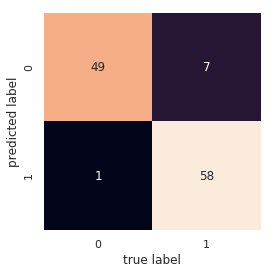

In [97]:
# Not very important, confusion matrix plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print 'Confusion Matrix'
mat = confusion_matrix(y_final_test, y_pred_test) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

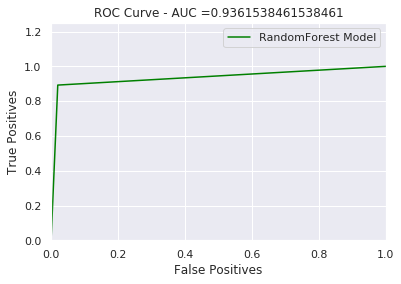

In [98]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Getting rid of warning for .as_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ROC Curve for RandomForest
probs = clf.predict(x_final_test)

merged_array = df_test.as_matrix(columns=df_test.columns[:1])

fpr, tpr, thresholds = roc_curve(merged_array, probs)
auc_RF = metrics.auc(fpr,tpr)

plt.xlim(0, 1.0)
plt.ylim(0, 1.25)
plt.plot(fpr,tpr, color='green', label='RandomForest Model')
plt.title("ROC Curve - AUC ="+str(auc_RF))
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.legend()
plt.show()

In [99]:
# Check that all are merged hits i.e. isSharedHit=1
print df_test['isSharedHit'].head()

print df_train['isSharedHit'].head()

25     1
92     1
140    1
324    1
331    1
Name: isSharedHit, dtype: int32
4617    1
7640    1
1080    1
7494    1
5828    1
Name: isSharedHit, dtype: int32


In [100]:
print df_test.shape
print df_train.shape

(115, 43)
(174, 43)


In [101]:
from keras.layers import Dense, Dropout, Activation
# Define the network
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(4,4), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(4,4), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(2,2), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(1,1), padding='same', activation='relu'))
# max pooling 2D
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format="channels_last"))
model.add(keras.layers.Flatten(input_shape=(6,6,1),data_format = "channels_last"))
#model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
# dropout 10%
model.add(Dropout(0.1))
model.add(keras.layers.Dense(2, activation='softmax'))
#print(model.summary())
                                                    
# Train the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])
model.fit(images_train, keras.utils.to_categorical(df_train["nUniqueSimTracksInSharedHit"]>1), epochs=30, validation_split=0.1) # validation fraction
print(model.summary)

Train on 156 samples, validate on 18 samples
Epoch 1/30
156/156 [==============================] - 0s 2ms/step - loss: 0.6932 - acc: 0.4744 - val_loss: 0.6952 - val_acc: 0.4444
Epoch 2/30
156/156 [==============================] - 0s 129us/step - loss: 0.6817 - acc: 0.6346 - val_loss: 0.6891 - val_acc: 0.5000
Epoch 3/30
156/156 [==============================] - 0s 222us/step - loss: 0.6682 - acc: 0.6282 - val_loss: 0.6862 - val_acc: 0.5000
Epoch 4/30
156/156 [==============================] - 0s 133us/step - loss: 0.6530 - acc: 0.6474 - val_loss: 0.6821 - val_acc: 0.5000
Epoch 5/30
156/156 [==============================] - 0s 107us/step - loss: 0.6359 - acc: 0.6346 - val_loss: 0.6840 - val_acc: 0.4444
Epoch 6/30
156/156 [==============================] - 0s 104us/step - loss: 0.6177 - acc: 0.6410 - val_loss: 0.6769 - val_acc: 0.4444
Epoch 7/30
156/156 [==============================] - 0s 320us/step - loss: 0.5980 - acc: 0.6474 - val_loss: 0.6754 - val_acc: 0.5000
Epoch 8/30
156/156 

In [102]:
#store_test = pandas.HDFStore("pixelTrain30k.h5")

#df_test = store_test.select("df",stop=-1)
##pixels
#df_test[pixels]

In [103]:
### Evaluate performance on independent sample
# DO NOT CHANGE BELOW!

# Prepare input
#store_test = pandas.HDFStore("SNG_p10_pixelTrain.h5")


#store_test = pandas.HDFStore("pixelTest_v3.h5")
#store_test = pandas.HDFStore("pixelTrain30k.h5")

#df_test = store_test.select("df",stop=-1)
#df_test = df_test[(df_test["GenDeltaR"]<0.1) & (df_test["nUniqueSimTracksInSharedHit"]>-1)]#print(df_test)
#images_test = to_image(df_test)
#images_test = pandas.read_hdf("pixelTrain.h5")
#images_test = images_train
#df_test = df_train

# Run DNN
print("Running on full test sample. This may take a moment.")
ret = model.predict(images_test)
np.save("result.npy",ret[:,1])
print(ret)
#print ret
#print df_test["isSharedHit"]
#keras.utils.to_categorical(df_test["isSharedHit"])
#print len(keras.utils.to_categorical(df_test["isSharedHit"]))
#print keras.utils.to_categorical(df_train["isSharedHit"],dtype='int32').sum()
#print len(keras.utils.to_categorical(df_train["isSharedHit"])),keras.utils.to_categorical(df_train["isSharedHit"]).sum()

Running on full test sample. This may take a moment.
[[0.86367273 0.13632727]
 [0.33504027 0.6649597 ]
 [0.621781   0.378219  ]
 [0.58943814 0.41056186]
 [0.62625414 0.3737458 ]
 [0.8652039  0.1347961 ]
 [0.8939384  0.10606164]
 [0.4143256  0.58567446]
 [0.39262182 0.6073782 ]
 [0.13199022 0.8680098 ]
 [0.6313606  0.36863944]
 [0.55366075 0.44633928]
 [0.7859291  0.21407093]
 [0.6660059  0.33399412]
 [0.02784233 0.9721577 ]
 [0.0881343  0.91186565]
 [0.4133895  0.58661056]
 [0.04944958 0.9505504 ]
 [0.39731243 0.60268754]
 [0.34117082 0.6588292 ]
 [0.11619178 0.8838082 ]
 [0.06702919 0.93297076]
 [0.8227611  0.17723888]
 [0.7990948  0.20090517]
 [0.46140173 0.53859824]
 [0.09529932 0.90470064]
 [0.1329486  0.8670514 ]
 [0.8536216  0.14637832]
 [0.11647966 0.88352036]
 [0.09165178 0.90834814]
 [0.11842925 0.8815708 ]
 [0.73701763 0.2629824 ]
 [0.49381727 0.5061828 ]
 [0.8384104  0.16158961]
 [0.574801   0.425199  ]
 [0.08686254 0.9131375 ]
 [0.3798284  0.6201716 ]
 [0.09069878 0.9093013

In [104]:
from sklearn.metrics import roc_curve
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(df_test["isSharedHit"])[:,1], ret[:,1])
fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(df_test["nUniqueSimTracksInSharedHit"]>1)[:,1], ret[:,1])

print fpr_keras,tpr_keras
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print auc_keras
print np.isnan(fpr_keras).all()
print len(fpr_keras),len(tpr_keras)
np.save("fpr_keras.npy",fpr_keras)
np.save("tpr_keras.npy",tpr_keras)

[0.   0.   0.02 0.02 0.04 0.04 0.08 0.08 0.1  0.1  0.12 0.12 0.14 0.14
 0.16 0.16 0.26 0.26 0.34 0.34 0.44 0.44 0.46 0.46 0.52 0.52 0.54 0.58
 0.74 0.74 1.  ] [0.01538462 0.41538462 0.41538462 0.49230769 0.49230769 0.56923077
 0.56923077 0.73846154 0.73846154 0.78461538 0.78461538 0.81538462
 0.81538462 0.84615385 0.84615385 0.89230769 0.89230769 0.90769231
 0.90769231 0.92307692 0.92307692 0.93846154 0.93846154 0.95384615
 0.95384615 0.96923077 0.96923077 0.98461538 0.98461538 1.
 1.        ]
0.9107692307692308
False
31 31


0.9107692307692308


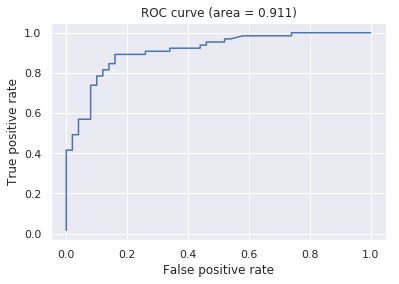

In [105]:
import numpy as np
fpr_keras = np.load("fpr_keras.npy")
tpr_keras = np.load("tpr_keras.npy")
#print fpr_keras[2300]
auc = np.trapz(tpr_keras,fpr_keras)
print auc
#auc_keras = 0.623416233325797
#auc_keras = 0.665570454761781
#print test
import matplotlib.pyplot as plt
plt.figure(1)
#plt.figure(figsize=(200, 200))
#plt.plot([0, 1], [0, 1], label='test')
#plt.plot([1,2,3],[5,6,7], label = 'test')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
#plt.plot(fpr_keras, tpr_keras, label='test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = {:.3f})'.format(auc))
#plt.legend(loc='best')
plt.savefig("ROC.png")
plt.savefig("ROC.pdf")

plt.show()


In [106]:
#sanity check: no overlap between train and test
pandas.merge(df_train, df_test, on=[x for x in df_train.columns], how='inner')

,isMergedHit,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35


In [107]:
df_train.shape

(174, 43)

In [108]:
df_test.shape

(115, 43)

In [109]:
#df_test[(df_test["nUniqueSimTracksInSharedHit"]>-1) & (df_test["GenDeltaR"]<0.1)]

shared hits with at least 2 sim tracks:
0.563218390805


Text(0.5,1,'nUniqueSimTracksInSharedHit')

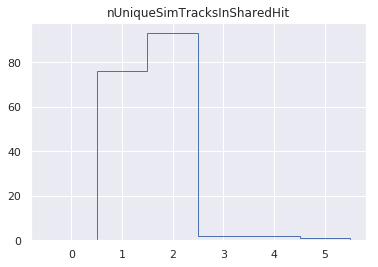

In [110]:
print "shared hits with at least 2 sim tracks:"
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"],histtype="step",bins=6,range=(-0.5,5.5))
plt.title("nUniqueSimTracksInSharedHit")

In [111]:
sum(df_train["nUniqueSimTracksInSharedHit"]>-1)

174

In [112]:
82.0/30000

0.0027333333333333333

In [113]:
import matplotlib.pyplot as plt

0.563218390805


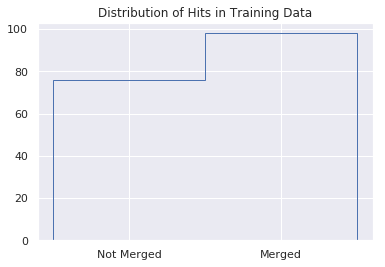

In [114]:
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"]>1,histtype="step",bins=2,range=(-0.5,1.5))
plt.title("Distribution of Hits in Training Data")
plt.xticks([0,1],("Not Merged","Merged"))
plt.savefig("merged_dist.png")
plt.savefig("merged_dist.pdf")

In [115]:
if auc_RF > auc:
    print "Random Forest model performed better"
    print "Area under RF ROC curve = " +str(auc_RF)
else: 
    print "CNN performed better"
    print "Area under CNN ROC curve = " +str(auc)


Random Forest model performed better
Area under RF ROC curve = 0.9361538461538461
